In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import datetime
import imageio as img
import os

In [16]:
nc_file = nc.Dataset('/localdata/cases/20180519/GLM_data/GLM-00-00_20180520_010000_60_1src_056urad-dx_source.nc', 'r')
nc_file

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): nx(3249), ny(1300), ntimes(1)
    variables(dimensions): int32 goes_imager_projection(), float32 x(nx), float32 y(ny), float32 time(ntimes), float32 event_density(ntimes,nx,ny)
    groups: 

In [3]:
#Importing and preparing the GLM Data

In [17]:
#Constants

#Used for GLM timesteps/filenames
start_y = '2018'                                        #Format: YYYY(UTC-Relative)
start_m = '05'                                          #Format: MM(UTC-Relative)
start_d =  '20'                                         #Format: DD(UTC-Relative)
start_h = '02'                                          #Format: HH (UTC-Relative)
start_M = '10'                                          #Format: MM (UTC-Relative)

end_y = '2018'                                          #Format: YYYY(UTC-Relative)
end_m = '05'                                            #Format: MM(UTC-Relative)
end_d =  '20'                                           #Format: DD(UTC-Relative)
end_h = '07'                                            #Format: HH (UTC-Relative)
end_M = '00'                                            #Format: MM (UTC-Relative)

#GLM Data Info
GLM_file_location = '/localdata/cases/20180519/GLM_data/' #Location of the data that you are pulling from
GLM_name_start = 'GLM-00-00_'                          #First part of the file name before the time
GLM_name_end = '_60_1src_056urad-dx_'                  #Last part of the file name after the time

GLM_var_name = 'source'                               #Variable that is used in the file name
GLM_var_units = ' (Events per Min)'
GLM_data_name = 'event_density'                      #Variable that is used to pull the data from the netCDF file
GLM_full_name = 'Maximum Event Density'
file_type = '.nc'                                       #Datatype for netCDF file

#MRMS Data Info
MRMS_file_loc = '/localdata/cases/20180519/merged_radar/merged/'
MRMS_product1 = 'MESH/00.25/'
MRMS_var1_name = 'MESH'
MRMS_var1_fullname = 'Maximum MESH'
MRMS_var1_units = ' (mm)'
MRMS_contour_val = 40
spacing = 0.01 #MRMS spacing between points
data_crs = ccrs.PlateCarree()

plot_type = 'max-'      #'max','sum'
save_location = '/localdata/cases/20180519/GLM_MRMS_pics/timeseries/'+plot_type     #Name of a premade folder to save the data to
save_filetype = '.png'
save_filename = MRMS_var1_name+'_VS_'+GLM_data_name+save_filetype


In [18]:
#Setting the start and end times
start_time = start_y + start_m + start_d + start_h + start_M                       
end_time = end_y + end_m + end_d + end_h + end_M

#Creating a list of start and end times to use for the loop and for plotting
time = pd.PeriodIndex(start = start_time, end = end_time, freq='T')
time_ymd = time.strftime('%Y%m%d')
time_hms = time.strftime('%H%M%S')
time_hm = time.strftime('%H%M')

time_Y = time.strftime('%Y')
time_m = time.strftime('%m') #month
time_D = time.strftime('%D')
time_H = time.strftime('%H')
time_M = time.strftime('%M') #Minute
time_S = time.strftime('%S')

#Used for the timeseries
timeseries = time.to_timestamp()

In [19]:
#Creating an array of file_names using the start_time and end_time
i = 0
GLM_file_names = np.empty([0])
while i < len(time):
    name = GLM_file_location + GLM_name_start + time_ymd[i] + '_' + time_hms[i]+ GLM_name_end + GLM_var_name + file_type
    GLM_file_names = np.append(GLM_file_names, name)
    i += 1

In [20]:
#Setting the locations to pull the data from (use Basic_Plot_GLM.ipynb to get bounds)
x_locs = np.arange(1600,1851,1)
y_locs = np.arange(740,811,1)

In [21]:
#Pulling the maximum value from the GLM variable per timestep 
k = 0
max_GLM_data = np.zeros(len(GLM_file_names))
while k < len(GLM_file_names):
    nc_file_GLM = nc.Dataset(GLM_file_names[k],'r') #Loading in the GLM Data
    GLM_var = nc_file_GLM.variables[GLM_data_name][:,:]
    GLM_var = np.squeeze(GLM_var) #Reducing the dimensionality to 2D
    GLM_var[GLM_var==0] = np.nan #Removing the zeros (to NaN's)
    
    x = nc_file_GLM.variables['x'][:] #Getting the x points for the data
    y = nc_file_GLM.variables['y'][:] #Getting the y points for the data
    
    GLM_iso_var = np.ones((len(x),len(y)))*np.nan
    
    for i in x_locs: #Loop to fill GLM_iso_var with only the data in the predefined bounds
        for j in y_locs:
            GLM_iso_var[i,j] = GLM_var[i,j]
    
    max_GLM_data[k] = np.nanmax(GLM_iso_var)
    k += 1

/localdata/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: All-NaN slice encountered


In [22]:
print (np.nanmax(max_GLM_data))

208.00143432617188


In [23]:
#Importing and preparing the MRMS data

In [24]:
#Gets the maximum value from each netCDF file in the folder and the timeseries data
max_MRMS_data = np.empty([0])
time_MRMS = np.empty([0])
MRMS_filename_list = np.empty([0])
MRMS_hm = np.empty([0])

for MRMS_filename in os.listdir(MRMS_file_loc+MRMS_product1):
    nc_file_MRMS = nc.Dataset(MRMS_file_loc+MRMS_product1+MRMS_filename, 'r')
    MRMS_filename_list = np.append(MRMS_filename_list, MRMS_filename)#Getting the list of MRMS Filenames
    #makes the variable from the netCDF file into a local variable that we can use when plotting data
    MRMS_var1 = nc_file_MRMS.variables[MRMS_var1_name][:,:]
    max_MRMS_data = np.append(max_MRMS_data, np.nanmax(MRMS_var1)) #Pulling the maximum values in the MRMS data
    
    dtime = datetime.datetime.utcfromtimestamp(nc_file_MRMS.Time) #Timesteps to use for the timeseries
    MRMS_hm = np.append(MRMS_hm, dtime.strftime('%H%M')) #List of times to use for the plot loop
    time_MRMS = np.append(time_MRMS, dtime)

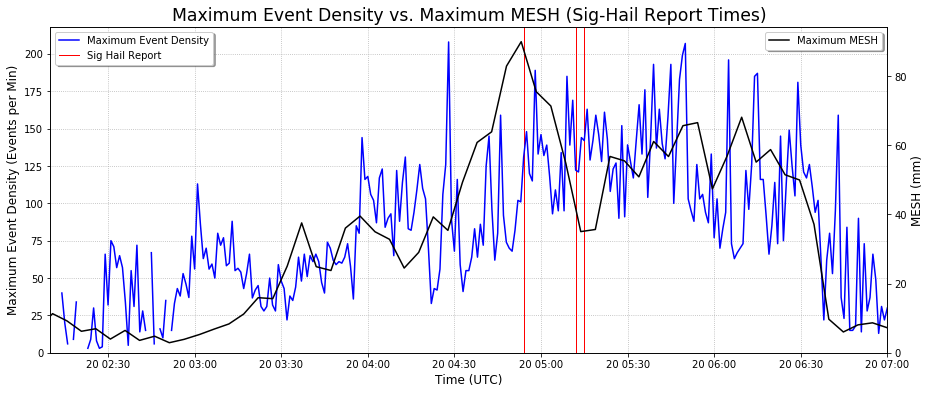

In [25]:
#building the timeseries plot
fig = plt.figure(figsize=(15, 6))
ax2 = plt.subplot(1, 1, 1)
ax3 = ax2.twinx()
ax2.plot(timeseries, max_GLM_data, color='b', zorder=5, label=GLM_full_name)
ax3.plot(time_MRMS, max_MRMS_data, color='k', label=MRMS_var1_fullname)
ax2.grid(True, linestyle=':', zorder=1)
ax2.axvline(pd.Timestamp('2018-05-20 04:54'), color='r', linewidth='1', zorder=2, label='Sig Hail Report')
ax2.axvline(pd.Timestamp('2018-05-20 05:12'), color='r', linewidth='1', zorder=3)
ax2.axvline(pd.Timestamp('2018-05-20 05:15'), color='r', linewidth='1', zorder=4)
ax2.set_ylim(0,)
ax3.set_ylim(0,)
ax2.set_xlim(pd.Timestamp(timeseries[0]),pd.Timestamp(timeseries[-1]))
plt.title(GLM_full_name+' vs. '+MRMS_var1_fullname+' (Sig-Hail Report Times)', fontsize='xx-large', loc='center')
ax2.set_xlabel('Time (UTC)', fontsize='large')
ax2.set_ylabel(GLM_full_name+GLM_var_units, fontsize='large')
ax3.set_ylabel(MRMS_var1_name+MRMS_var1_units, fontsize='large')
ax2.legend(loc='upper left',shadow=True)
ax3.legend(loc='upper right',shadow=True)

plt.savefig(save_location+save_filename)
plt.show()